#### This script will perform Hyperbolic Ratio Parameters and save them as a dict -> .pkl file
#### 1| save parameters
#### 2| plot data
#### 3|Save data as a .mat file to compare with martins code 

In [54]:
# load packages
import numpy as np 
from scipy.io   import  loadmat
import pandas as pd
import os
import matplotlib.pyplot as plt #import matplotlib as plt
from scipy.optimize import curve_fit 
import seaborn as sns #import mat73
import pickle as pkl
from datetime import datetime

In [55]:
NumBins = 6 # number of contrasts
NumHarms = 2 # number of harmonic data: 2F1, 4F1
NumComp = 0 # first component from RCA
NumConds = 4

In [56]:
cp1 = sns.color_palette("cubehelix",12) 
cp2 = sns.color_palette("hls", 12)

In [57]:
# Main Directory of processed file from MatLab
MainDir = 'D:\\AttnXV3_analysis\\RCA_F1\\AvgCRFs\\' # set dir
os.chdir(MainDir) # change old dir, to this dir
d = os.listdir(MainDir) # list files in dir
print(f'Files on hand: {d}')
##############################################
FileN = d[-1] # choose one                        
file_path1 = os.path.join(MainDir, FileN) # join paths and prep 2 load
print('Current WD:',file_path1) # does path exist ... ?
print('Does File #1 Exist?',os.path.exists(file_path1)) # yes or no

Files on hand: ['F1AverageCRF_20240205_154708.pkl', 'F1AverageCRF_20240205_162024.mat', 'F1AverageCRF_20240205_162024.pkl', 'F1AverageCRF_20240206_104806.pkl', 'F1AverageCRF_20240207_124816.pkl', 'AllCondCRF_AllSess_20240210_1038.pkl', 'AllCondCRF_AllSess_20240211_1701.pkl', 'AllCondCRF_AllSess_20240212_1128.pkl', 'AllCondCRF_AllSess_20240213_1141.mat', 'AllCondCRF_AllSess_20240213_1141.pkl']
Current WD: D:\AttnXV3_analysis\RCA_F1\AvgCRFs\AllCondCRF_AllSess_20240213_1141.pkl
Does File #1 Exist? True


In [58]:
loadData = pkl.load(open(file_path1,'rb'))
print(loadData.keys())

dict_keys(['Data', 'SubNames', 'VoiceMemo', 'DictMainKeys', 'ContLevs', 'crfLabs'])


In [59]:
data = loadData['Data']
data_labels = loadData['DictMainKeys']
SubNames = np.array(loadData['SubNames'])
note = loadData['VoiceMemo']
contrast_levels = loadData['ContLevs']
contrast_labs = loadData['crfLabs']
print(note)
NumSubs = int(len(SubNames))
print(data_labels) # labels for nr plots

['This file contains all subjects who did both sessions, avg of CRF [12x2] array, original crfs']
['attnL F1', 'attnL F2', 'attnR F1', 'attnR F2']


#### Naka Rushton Model Function

In [60]:
def naka_rushton(C, C50, n, Rmax, b):
    """
    This function models neural responses captured by Contrast Response Functions
     
    C50 (parameter 1) : Contrast level that yields half of max response (contrast %)
    n (parameter 2)   : Determines the curve arc for fitting (small integer)
    Rmax (Parameter 3): Max response elicited (mv)
    b (Parameter 4)   : Starting value (origin)
    """
    return ((Rmax * ((C**n) / (C50**n + C**n)))+b)

In [61]:
def ReshapeData(NumConds,NumBins,x):
    """
    This function reshapes CRF data for all conditions to feed into scipy optimally
    12 x 2 -> 4 x6 array for scipy curve fit
    """
    dictOut = {}
    NumSubs = int(len(x.keys())) # 25
    for i in (range(NumSubs)):
        yOut = np.zeros((NumConds,NumBins)) # how data is going to be stored
        yIn = x[i]
        yOut[0,:] = yIn[:NumBins,0] # 2f Pre
        yOut[1,:] = yIn[:NumBins,1] # 2f Post
        yOut[2,:] = yIn[NumBins:,0] # 4f Pre
        yOut[3,:] = yIn[NumBins:,1] # 4f Post
        dictOut[i] = np.array(yOut)
    return dictOut
#######################################################################################################
def FixSuperSat(DictIn,NumBins,NumConds,NumSubs):
    """
    Fix Supersaturation at higher contrasts by setting proceeding vals to max val
    before supersaturation occurs, basically lift drooping *tail*
    DictIn = Dict key 
    """
    dictOut = {}
    for i in range(NumSubs):
        aIn = DictIn[i] # 4x6
        aOut = np.zeros_like(aIn)
        max_pos, max_val = np.argmax(aIn,axis=1), np.max(aIn,axis=1) # 4 array 
        for co in range(NumConds):
            pos = max_pos[co]
            amp = max_val[co]
            if pos < NumBins:
                aOut[co,:pos] = aIn[co,:pos]
                aOut[co,pos:] = amp
            else:
                aOut[co,:] = aIn[co,:]
        dictOut[i] = aOut
    return dictOut
#######################################################################################################
def HyperRatComputation(NumConds,NumSubs,naka_rushton,contrast_levels,init_g1,init_g2,boundaries,xDict):
    """
    Run Curve Fit for each condition for 1 subject at the same time and save params into dict
    Goal : save cov to plot error bars!!!
    """

    nr_data = {}
    for subj in range(NumSubs):
        dIn = xDict[subj]
        nr_out = np.zeros((NumConds,NumConds)) # 4 x 4 array
        for cond in range(NumConds):
            #if c<=2:
            if cond<=1:
                # NR for 2F harmonic pre and post
                p, cov = curve_fit(naka_rushton,contrast_levels,dIn[cond,:],p0 = init_g1, bounds = boundaries, nan_policy = 'omit', method = 'trf' )
            else:
                # NR for 4F harmonic pre and post
                p, cov = curve_fit(naka_rushton,contrast_levels,dIn[cond,:],p0 = init_g2, bounds = boundaries, nan_policy = 'omit', method = 'trf')
            nr_out[cond,:] = p
        nr_data[subj] = np.array(nr_out)
    return nr_data
#######################################################################################################
def SmoothHyperRat(naka_rushton,NumConds,NumSubs,ContrastEnd,Full_Contrasts,dict_In):# = HyperBolicParams[0]):
    'Run Naka Rushton Model for all contrasts 1% - 100% for all conditions, return dict'
    dictOut = {}
    for i in range(NumSubs):
        xIn = dict_In[i] # 4x4 array 
        xOut = np.zeros((NumConds,ContrastEnd)) # 
        for co in range(NumConds):                   # c50   |   n    |  Rmax  |    b
            hyperRat = naka_rushton(Full_Contrasts,xIn[co,0],xIn[co,1],xIn[co,2],xIn[co,3])
            xOut[co,:] = hyperRat
        dictOut[i] = xOut
    return dictOut

#### Reshape Data to Feed into SciPy

In [62]:
pyData = {} # reshaped data to enter into curve fit
for co in range(NumConds):
    pyData[co] = ReshapeData(NumConds,NumBins,x=data[co])

#### Remove SuperSaturation

In [63]:
pyData_clean = {}
for co in range(NumConds):
    pyData_clean[co] = FixSuperSat(pyData[co],NumBins,NumConds,NumSubs)

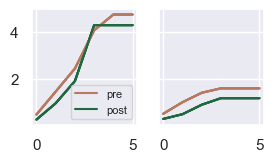

In [64]:
# sanity check for everything thats been done so far ...
sns.set_theme()
fig,axs = plt.subplots(1,2, figsize = (3,1.5),sharey=True)
#############    Compare Here    #################
d = pyData_clean[2] # no super saturation CRF's  #
#d = pyData[2] # original data CRF               #
##################################################
a = np.array(d[3]) # 4x 6 
for i in range(NumConds):
    axs[0].plot(a[0,:],label = 'pre', color =  cp1[6])
    axs[0].plot(a[1,:],label='post', color = cp1[3])
    if i  == 0:
        axs[0].legend(loc = 'lower right', fontsize = 8)

    axs[1].plot(a[2,:],label = 'pre', color =  cp1[6])
    axs[1].plot(a[3,:],label='post', color = cp1[3])

#### Set Boundaries and Initial Est

In [65]:
### Model Estimates...based on nothing soild - subject to change 
c50_b = [0,300]
n_b = [0,5] # [0,10]
Rmax_b = [0,10] # [0,10]
b_b = [0,3]
boundaries=([c50_b[0],n_b[0],Rmax_b[0],b_b[0]], [c50_b[1],n_b[1],Rmax_b[1],b_b[1]]) # Boundary Params for C50, N, Rmax and B
init_g1 = [20,3,4,0.5] # Initial guess for 2f params
init_g2 = [10,1,2,0.5] # Initial guess for 4f params

param_names=['C50','n','Rmax','b']

#### Run Curve Fit

In [66]:
HyperBolicParams = {}
for i in range(NumConds):
    HyperBolicParams[i] = HyperRatComputation(NumConds,NumSubs,naka_rushton,contrast_levels, init_g1,init_g2, boundaries, xDict = pyData_clean[i])

#### Re-Run Hyperbolic Ratio Params Into HyperRat for a Smoother Fit

In [67]:
Full_Contrasts = np.array(np.arange(0.1,100,0.1)) # all contrast from 1% - 100% - ~1k data points
ContrastEnd = (Full_Contrasts.shape[0])
print('length of x array for contrasts: ', Full_Contrasts.shape)

x1 = np.linspace(0, 100, NumBins) # all 6 contrasts
x2 = np.linspace(0, 100, ContrastEnd) # all 100 contrasts

length of x array for contrasts:  (999,)


In [68]:
RefinedHyperBolicParams = {}

for i in range(NumConds):
    RefinedHyperBolicParams[i] = SmoothHyperRat(naka_rushton, NumConds,NumSubs,ContrastEnd,Full_Contrasts, dict_In = HyperBolicParams[i])

In [ ]:
#def GenImgs():



#    return fig, axs

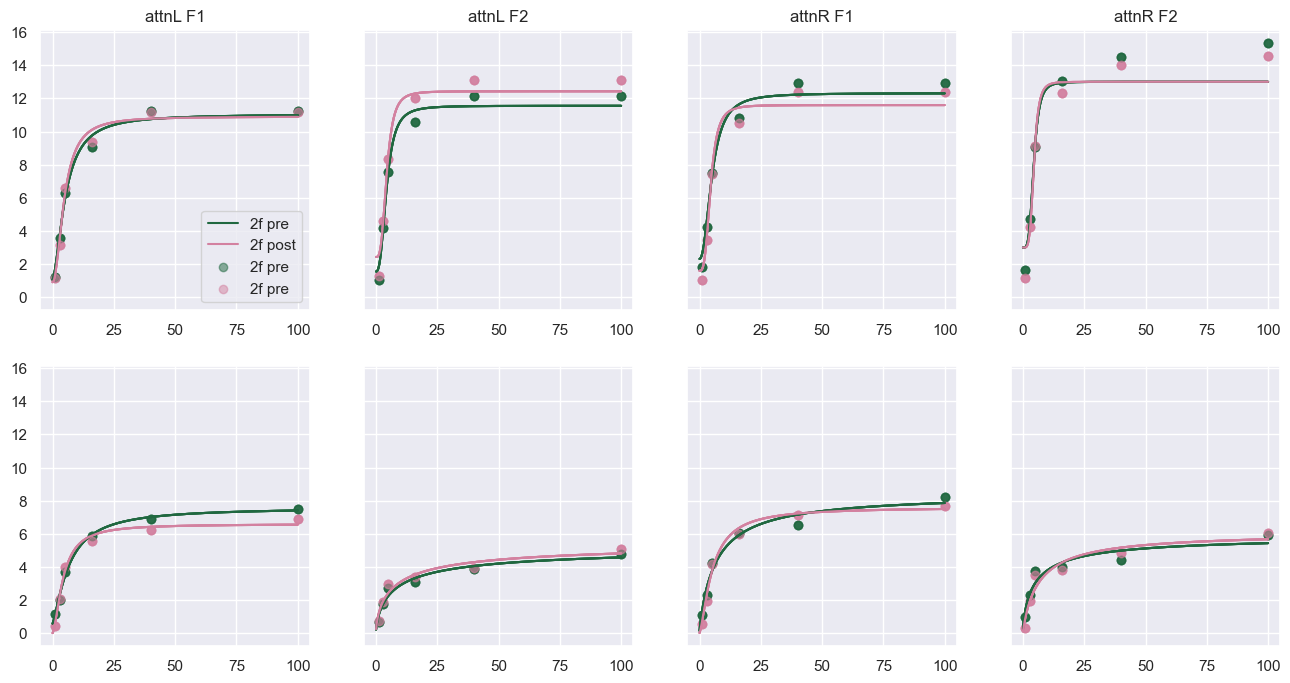

In [83]:
# plot smooth data
fig,axs = plt.subplots(2,4, figsize = (16,8),sharey=True)

subj = 0
for Files in range(NumConds):
    dataIn_nr = RefinedHyperBolicParams[Files][subj]
    dataIn_crf = pyData_clean[Files][subj]
 
    for i in range(NumConds):
        axs[0,Files].plot(x2,dataIn_nr[0,:],color = cp1[3], label = '2f pre')
        axs[0,Files].plot(x2,dataIn_nr[1,:],color = cp1[7], label = '2f post')

        axs[0,Files].scatter(contrast_levels,dataIn_crf[0,:],color = cp1[3],alpha = 0.5, label = '2f pre')
        axs[0,Files].scatter(contrast_levels,dataIn_crf[1,:],color = cp1[7],alpha = 0.5, label = '2f pre')

        axs[0,Files].set_title(f'{data_labels[Files]}')

        #########################################################################
        if Files == 0 and i == 0:
            axs[0,Files].legend(loc = 'lower right')
        axs[1,Files].plot(x2,dataIn_nr[2,:],color = cp1[3], label = '4f pre')
        axs[1,Files].plot(x2,dataIn_nr[3,:],color = cp1[7], label = '4f post')
            
        axs[1,Files].scatter(contrast_levels,dataIn_crf[2,:],color = cp1[3],alpha = 0.5, label = '4f pre')
        axs[1,Files].scatter(contrast_levels,dataIn_crf[3,:],color = cp1[7],alpha = 0.5, label = '4f pre')

### dont touch!!! yet

In [ ]:
fig,axs = plt.subplots(2,4, figsize = (12,6),sharey=True)

subj = 12
for Files in range(NumConds):
    dataIn = pyData_clean[Files][subj]
    #print(dataIn)
    #print() 
    for i in range(NumConds):
        axs[0,Files].scatter(contrast_levels,dataIn[0,:],color = cp1[0], label = '2f pre' )
        axs[0,Files].scatter(contrast_levels,dataIn[1,:],color = cp1[7], label = '2f post')
        axs[0,Files].set_title(f'{data_labels[Files]}')
        if Files == 0 and i == 0:
            axs[0,Files].legend(loc = 'lower right')
        axs[1,Files].scatter(contrast_levels,dataIn[2,:],color = cp1[0], label = '4f pre')
        axs[1,Files].scatter(contrast_levels,dataIn[3,:],color = cp1[7], label = '4f post')

        

In [ ]:
fig,axs = plt.subplots(2,4, figsize = (12,6),sharey=False)

subj = 12
for Files in range(NumConds):
    dataIn_crf = pyData_clean[Files][subj]
    dataIn_nr = HyperBolicParams[Files][subj]
    #print(dataIn)
    #print() 
    for i in range(NumConds):
        model_data = naka_rushton(Full_Contrasts,dataIn_nr[0,0],dataIn[0,1],dataIn[0,2],dataIn[0,3])
        print(model_data.shape)
        axs[0,Files].plot(model_data, color = cp1[0])
        axs[0,Files].scatter(contrast_levels,dataIn_crf[0,:],color = cp1[0], label = '2f pre' )

        axs[0,Files].plot(model_data, color = cp1[0])
        axs[0,Files].scatter(contrast_levels,dataIn_crf[0,:],color = cp1[0], label = '2f pre' )
        #axs[1,Files].scatter(contrast_levels,dataIn_crf[0,:],color = cp1[0], label = '2f pre' )
        #print(model_data.shape)
        #print(dataIn_crf[0,:].shape)
        #axs[0,Files].#scatter(contrast_levels,dataIn[1,:],color = cp1[7], label = '2f post')
        #axs[0,Files].set_title(f'{data_labels[Files]}')
        #if Files == 0 and i == 0:
        #    axs[0,Files].legend(loc = 'lower right')
        #axs[1,Files].#scatter(contrast_levels,dataIn[2,:],color = cp1[0], label = '4f pre')
        #axs[1,Files].#scatter(contrast_levels,dataIn[3,:],color = cp1[7], label = '4f post')

        

In [ ]:
testnr = HyperBolicParams[1][0]
testpyData = pyData[1][0]

#Full_Contrasts = np.arange(0,100,1)
Full_Contrasts = np.array(np.arange(0.1,100,0.1))
ContrastEnd = (Full_Contrasts.shape[0])
print('length of x array for contrasts: ', Full_Contrasts.shape)

x1 = np.linspace(0, 1, NumBins) # all 6 contrasts
x2 = np.linspace(0, 1, ContrastEnd) # all 100 contrasts
#print(len(x1))
#print(len(x2))

sns.set_theme()

for j in range(4):
    fig, axs = plt.subplots(1,2, figsize = (9,4.5), sharey= False, sharex = False)
    i = j
    axs[0].plot(naka_rushton(contrast_levels, testnr[i,0], testnr[i,1], testnr[i,2], testnr[i,3]), label = 'Expt Contrasts', color = cp1[0])
    axs[0].scatter(contrast_levels,testpyData[i,:], label = 'CRF', color = cp2[5])

    axs[0].legend()

    sim = naka_rushton(Full_Contrasts, testnr[i,0], testnr[i,1], testnr[i,2], testnr[i,3])
    axs[1].plot(x2,sim, label = 'All Contrasts', color = cp2[7])
    axs[1].plot(x1,naka_rushton(contrast_levels, testnr[i,0], testnr[i,1], testnr[i,2], testnr[i,3]), label = 'Expt Contrasts',color = cp1[0])
    #axs[1].scatter(contrast_levels,testpyData[i,:], label = 'CRF', color = cp2[5])

    axs[1].legend()